In [1]:

!pip install sklearn


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from sklearn.model_selection import KFold
from sklearn.metrics import precision_recall_curve, roc_curve, auc, roc_auc_score, precision_score, recall_score, f1_score

In [14]:
config = {
    "mathtext.fontset": 'stix',
    "font.family": 'serif',
    "font.serif": ['SimHei'],
    "font.size": 10,
    'axes.unicode_minus': False
}
rcParams.update(config)

In [23]:
path = r'C:\\Users\\15359\\Desktop\\luyunhao\\ex2data1.txt'  
data = pd.read_csv(path)
X_data= data.iloc[:, :2]  #选择前两列
y_data= data.iloc[:, 2]   #选择第三列

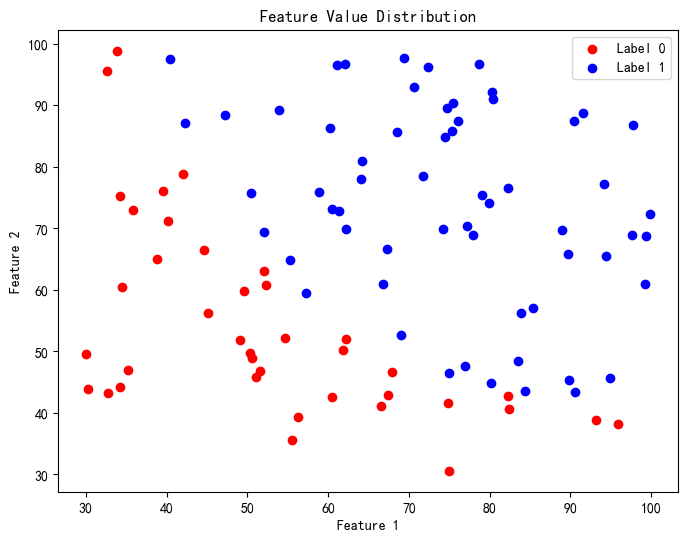

In [16]:
plt.figure(figsize=(8, 6))
plt.scatter(X_data[y_data==0].iloc[:, 0],X_data[y_data==0].iloc[:, 1], c='red', label='Label 0')
plt.scatter(X_data[y_data==1].iloc[:, 0],X_data[y_data==1].iloc[:, 1], c='blue',label='Label 1')
plt.title('Feature Value Distribution')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()

In [17]:
#定义归一化函数
def normalize_minmax(X):
    min_val = np.min(X, axis=0)
    max_val = np.max(X, axis=0)
    X_norm = (X - min_val) / (max_val - min_val)
    return X_norm, min_val, max_val
#对特征数据进行归一化处理
X_data_norm, min_val, max_val = normalize_minmax(X_data.values)
#在归一化后的数据前添加一列全1，代表x0，并重新命名
X_data_norm = np.insert(X_data_norm, 0, 1, axis=1) 
X= X_data_norm
y = y_data.values.reshape(-1, 1)
#初始化模型参数
feature_dim=X.shape[1] 
W=np.zeros((feature_dim,1))

In [18]:
def sigmoid(z):return 1/(1+np.exp(-z))
#定义损失函数
def computeCost(X, Y, W):
    P = sigmoid(np.dot(X, W))
    loss = np.sum(-Y * np.log(P) - (1 - Y) * np.log(1 - P)) / len(Y)
    return loss, P
#定义梯度下降函数
def gradientDecent(W, X, Y, alpha):
    error = sigmoid(np.dot(X, W)) - Y
    grad = np.dot(X.T, error) / len(Y)
    W = W - alpha * grad
    return W
#定义模型函数
def logisticRegression(X, Y, alpha, iters):
    feature_dim = X.shape[1]
    W = np.zeros((feature_dim, 1))
    loss_his = []
    W_his = []
    for i in range(iters):
        loss, P = computeCost(X, Y, W)
        loss_his.append(loss)
        W_his.append(W.copy())  
        W = gradientDecent(W, X, Y, alpha)
    return loss_his, W_his, W
#定义测试模型函数
def testmodel(X, Y, W_his, iters):
    testloss_his = []
    for i in range(min(iters, len(W_his))): 
        loss, P = computeCost(X, Y, W_his[i])
        testloss_his.append(loss)
    return testloss_his,P

In [19]:
alpha = 0.0066
iters = 100000
all_precision = 0
all_recall = 0
all_f1 = 0
all_auc=0
fpr_list = []
tpr_list = []
loss_sum = []
testloss_sum = []
W_models = []

In [20]:
kf = KFold(n_splits=5, shuffle=True, random_state=None)

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    #训练集数据训练模型
    loss_his,W_his, W = logisticRegression(X_train, y_train, alpha, iters)
    #测试集数据测试模型
    testloss_his,P = testmodel(X_test, y_test, W_his, iters)
    #保存每一折的w
    W_models.append(W)
    # 累积测试损失和测试损失历史
    loss_sum.append(loss_his)  
    testloss_sum.append(testloss_his) 
    # 计算 Precision、Recall、F1 Score
    precision = precision_score(y_test, np.round(P))
    recall = recall_score(y_test, np.round(P))
    f1 = f1_score(y_test, np.round(P))
    all_precision+=precision
    all_recall+=recall
    all_f1+=f1
    
    fpr, tpr, _ = roc_curve(y_test, P)
    roc_auc = auc(fpr, tpr)
    fpr_list.append(fpr)
    tpr_list.append(tpr)
    all_auc+=roc_auc

loss_average = np.mean(loss_sum, axis=0)
testloss_average = np.mean(testloss_sum, axis=0)

precision_average=all_precision/5
recall_average=all_recall/5
f1_average=all_f1/5

max_len = max(len(fpr) for fpr in fpr_list)
extended_fpr_list = [np.concatenate([fpr, np.full(max_len - len(fpr), np.nan)]) for fpr in fpr_list]
extended_tpr_list = [np.concatenate([tpr, np.full(max_len - len(tpr), np.nan)]) for tpr in tpr_list]
fpr_average = np.nanmean(extended_fpr_list, axis=0)
tpr_average = np.nanmean(extended_tpr_list, axis=0)
auc_average=all_auc/5

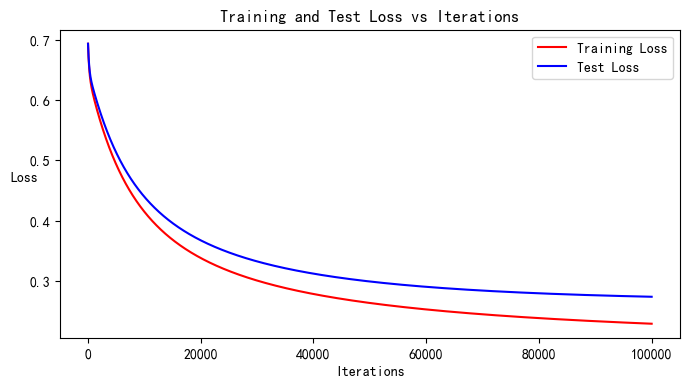

In [21]:
# 绘制训练集和验证集的损失曲线
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(np.arange(len(loss_average)), loss_average, 'r', label='Training Loss')
ax.plot(np.arange(len(testloss_average)), testloss_average, 'b', label='Test Loss')
ax.set_xlabel('Iterations')
ax.set_ylabel('Loss', rotation=0)
ax.set_title('Training and Test Loss vs Iterations')
ax.legend()
plt.show()

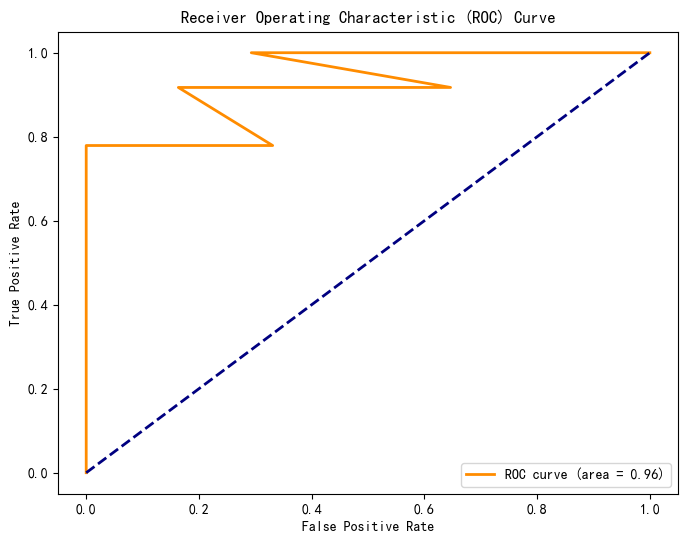

In [22]:
# 绘制 ROC 曲线
plt.figure(figsize=(8, 6))
plt.plot(fpr_average, tpr_average, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc_average)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [12]:
#输出
for i, W in enumerate(W_models, 1):
    print(f"Model {i}: W = {W.ravel()}")
print("Precision 平均值:", precision_average)
print("Recall 平均值:", recall_average)
print("F1 Score 平均值:", f1_average)

Model 1: W = [-7.19593637  8.327968    7.65030397]
Model 2: W = [-7.44484407  8.18801503  7.54817055]
Model 3: W = [-6.76308584  7.90382739  7.36375645]
Model 4: W = [-6.82272141  8.32602023  7.2497967 ]
Model 5: W = [-6.75336412  7.31990467  8.19874068]
Precision 平均值: 0.8976911976911979
Recall 平均值: 0.929059829059829
F1 Score 平均值: 0.9096681096681095
